In [2]:
pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 22.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 22.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.0/398.0 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.1 MB/s eta 0:00:00a 0:00

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [5]:
model = ResNet50(weights='imagenet')


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


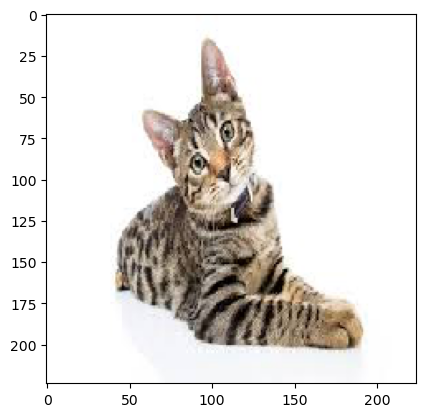

In [7]:
img_path = 'cat.jpeg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))  # ResNet expects 224x224 size images
plt.imshow(img)
plt.show()

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Reshape to (1, 224, 224, 3)
img_array = preprocess_input(img_array)

In [9]:
preds = model.predict(img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


In [10]:
print('Predicted:', decode_predictions(preds, top=3)[0])

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
Predicted: [('n02123045', 'tabby', 0.9407531), ('n02124075', 'Egyptian_cat', 0.029829657), ('n02123159', 'tiger_cat', 0.01859491)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Adversarial Predicted: [('n01930112', 'nematode', 0.06597664), ('n03729826', 'matchstick', 0.024977926), ('n04153751', 'screw', 0.022922171)]


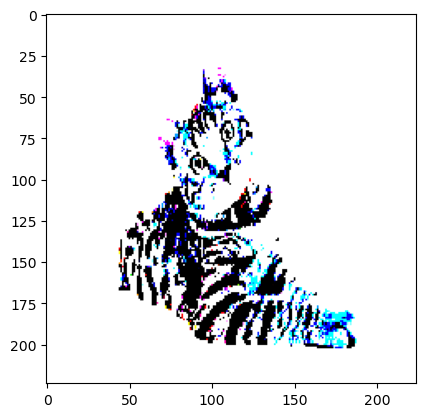

In [16]:
# Function to create adversarial example using FGSM
def create_adversarial_pattern(model, input_image, input_label):
    # Convert input image to a tensor
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)

    # Reshape input_label to match the batch size of the input image
    input_label = tf.convert_to_tensor([input_label], dtype=tf.int64)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(input_label, prediction)

    # Get the gradients of the loss w.r.t. the input image
    gradient = tape.gradient(loss, input_image)

    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad



# Assume this is the true label of the image (use the top prediction from the previous step)
label = np.argmax(preds)

# Create adversarial example
perturbations = create_adversarial_pattern(model, img_array, label)

# Set epsilon (perturbation factor)
epsilon = 0.01
adversarial_image = img_array + epsilon * perturbations

# Clip the values to maintain valid image
adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)

# Predict using the adversarial example
adv_preds = model.predict(adversarial_image)
print('Adversarial Predicted:', decode_predictions(adv_preds, top=3)[0])

# Display the adversarial image
adversarial_image = adversarial_image[0]  # Remove batch dimension
adversarial_image = 0.5 * adversarial_image + 0.5  # De-normalize the image to display
plt.imshow(adversarial_image)
plt.show()
